# Benchmark models
This notebook saves a benchmarking script and runs it with different parameters in subprocesses.

We do this so that we're not loading a million models into the GPU memory, and to provide a clean slate for each run.

Scroll to the **Analysis** section of this notebook to see results.

Before running this, see `download_data.ipynb` and `convert_models.ipynb`.

## Setup

In [1]:
models = ["td", "centroid", "bu", "inference_td"]  # see convert_models.ipynb
# precisions = ["FP32", "FP16", "INT8"]
precisions = ["FP32", "FP16"]
test_data = "data/190719_090330_wt_18159206_rig1.2@15000-17560.mp4"
batch_sizes = [1, 16, 32]
batches = 4  # number of batches at the batch size specified to run over
reps = 3  # repetitions of the same parameter set

## Benchmarking

In [2]:
%%writefile benchmark_model.py
"""This script is written from benchmark_models.ipynb. Do not edit directly."""

# Disable tensorflow spam (needs to happen before tensorflow gets imported)
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # set to "2" to see TensorRT errors
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("tensorflow").addHandler(logging.NullHandler(logging.ERROR))

import numpy as np
import tensorflow as tf
import cv2
from time import perf_counter
from trtutils import OptimizedModel
import system
import argparse
import pandas as pd

system.disable_preallocation()
# system.summary()


def log_result(data, filename="benchmark.csv"):
    """Append a dictionary of scalar keys as a row to a CSV file."""
    df = pd.DataFrame({k: [v] for k, v in data.items()})
    
    if os.path.exists(filename):
        df = pd.concat([
            pd.read_csv(filename),
            df,
        ])
    df.to_csv(filename, index=False)


def read_frames(video_path, fidxs=None, grayscale=True):
    """Read frames from a video file.
    
    Args:
        video_path: Path to MP4
        fidxs: List of frame indices or None to read all frames (default: None)
        grayscale: Keep only one channel of the images (default: True)
    
    Returns:
        Loaded images in array of shape (n_frames, height, width, channels) and dtype uint8.
    """
    vr = cv2.VideoCapture(video_path)
    if fidxs is None:
        fidxs = np.arange(vr.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []
    for fidx in fidxs:
        vr.set(cv2.CAP_PROP_POS_FRAMES, fidx)
        img = vr.read()[1]
        if grayscale:
            img = img[:, :, [0]]
        frames.append(img)
    return np.stack(frames, axis=0)


def benchmark(data, model, **kwargs):
    """Benchmark a single model.
    
    Args:
        data: Numpy array of data that will serve as input of shape
            (n_imgs, height, width, channels) and dtype float32.
        model: Anything with a .predict() method
    
    Returns:
        A tuple of (latency, fps).
        
        latency: time per image in milliseconds
        fps: images per second
        
        These values will be returned for the second run of this function
        to discount graph tracing/warmup time.
    """
    t0 = perf_counter()
    model.predict(data, **kwargs)
    first_run = perf_counter() - t0

    t0 = perf_counter()
    model.predict(data, **kwargs)
    dt = perf_counter() - t0

    N = len(data)
    latency = (first_run * 1000) / N
    fps = N / first_run
    print(f"  First run: {latency:.2f} ms/img -> {fps:.2f} FPS")

    latency = (dt * 1000) / N
    fps = N / dt
    print(f"   Real run: {latency:.2f} ms/img -> {fps:.2f} FPS")
    
    return latency, fps


def benchmark_model_set(model, precision, test_data, batch_size, batches, log_filename="benchmark.csv"):
    """Benchmark a pair of TensorFlow and TensorRT models."""
    saved_model_path = f"data/{model}_savedmodel"  # SavedModel proto folder
    opt_model_path = f"data/{model}_trt_{precision}"

    tf_model = tf.keras.models.load_model(saved_model_path)
    opt_model = OptimizedModel(saved_model_dir=opt_model_path)

    N = int(batch_size * batches)
    if "inference_" in model:
        # Real data
        data = read_frames(test_data, np.arange(N))
        img_shape = data.shape[1:]
    else:
        # Dummy data
        test_data = "zeros"
        img_shape = tuple(tf_model.inputs[0].shape[1:])
        data = np.zeros((N,) + img_shape, dtype="float32")

    print("==========")
    print(f"Model: {model}")
    print(f"Precision: {precision}")
    print("==========")
    print(f"tf.keras.Model (batch size = {batch_size}):")
    print("Test inputs:", data.shape, data.dtype)
    tf_latency, tf_fps = benchmark(data, tf_model, batch_size=batch_size)
    print("==========")
    print()
    print("==========")
    print(f"TensorRT optimized model (batch size = {batch_size}):")
    print("Test inputs:", data.shape, data.dtype)
    trt_latency, trt_fps = benchmark(data, opt_model, batch_size=batch_size)
    
    latency_delta = trt_latency - tf_latency
    latency_prc = (latency_delta / tf_latency) * 100
    
    fps_delta = trt_fps - tf_fps
    fps_prc = (fps_delta / tf_fps) * 100
    
    print(f"   Latency: {latency_delta:.1f} ({latency_prc:.1f}%)")
    print(f"       FPS: +{fps_delta:.1f} (+{fps_prc:.1f}%)")
    print("==========")
    
    log_result({
        "model": model,
        "precision": precision,
        "test_data": test_data,
        "batch_size": batch_size,
        "engine_base": "tf",
        "engine": "tf",
        "latency": tf_latency,
        "fps": tf_fps,
        "img_height": img_shape[0],
        "img_width": img_shape[1],
        "img_channels": img_shape[2],
        "batches": batches,
        "n_imgs": N,
        "model_path": saved_model_path,
    }, filename=log_filename)
    
    log_result({
        "model": model,
        "precision": precision,
        "test_data": test_data,
        "batch_size": batch_size,
        "engine_base": "trt",
        "engine": f"trt_{precision.lower()}",
        "latency": trt_latency,
        "fps": trt_fps,
        "img_height": img_shape[0],
        "img_width": img_shape[1],
        "img_channels": img_shape[2],
        "batches": batches,
        "n_imgs": N,
        "model_path": opt_model_path,
    }, filename=log_filename)
    

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("model", type=str)
    parser.add_argument("precision", type=str)
    parser.add_argument("test_data", type=str)
    parser.add_argument("--batch_size", type=int, default=32)
    parser.add_argument("--batches", type=int, default=4)
    parser.add_argument("--log", type=str, default="benchmark.csv")
    args = parser.parse_args()

    benchmark_model_set(args.model, args.precision, args.test_data, args.batch_size, args.batches, log_filename=args.log)

Overwriting benchmark_model.py


In [3]:
%%capture logs
!rm benchmark.csv
for _ in range(reps):
    for model in models:
        for precision in precisions:
            for batch_size in batch_sizes:
                !python benchmark_model.py "{model}" "{precision}" "{test_data}" --batch_size {batch_size} --batches {batches}

In [4]:
# Uncomment this to see the stdout spam:
# print(logs.stdout)

## Analysis

In [5]:
# Setup some plotting stuff
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams["figure.facecolor"] = "w"
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["savefig.dpi"] = 600
mpl.rcParams["savefig.transparent"] = False
mpl.rcParams["font.size"] = 15
# mpl.rcParams["font.family"] = "sans-serif"
# mpl.rcParams["font.sans-serif"] = ["Arial"]
mpl.rcParams["axes.titlesize"] = "xx-large"  # medium, large, x-large, xx-large
mpl.style.use("seaborn-deep")

In [6]:
# Load the results of all runs
res = pd.read_csv("benchmark.csv")
res

,model,precision,test_data,batch_size,engine_base,engine,latency,fps,img_height,img_width,img_channels,batches,n_imgs,model_path
0,td,FP32,zeros,1,tf,tf,6.714595,148.929316,160,160,1,4,4,data/td_savedmodel
1,td,FP32,zeros,1,trt,trt_fp32,2.939577,340.185000,160,160,1,4,4,data/td_trt_FP32
2,td,FP32,zeros,16,tf,tf,0.679969,1470.654773,160,160,1,4,64,data/td_savedmodel
3,td,FP32,zeros,16,trt,trt_fp32,0.293243,3410.136173,160,160,1,4,64,data/td_trt_FP32
4,td,FP32,zeros,32,tf,tf,0.568675,1758.475142,160,160,1,4,128,data/td_savedmodel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,inference_td,FP16,data/190719_090330_wt_18159206_rig1.2@15000-17...,1,trt,trt_fp16,3.978696,251.338630,1024,1024,1,4,4,data/inference_td_trt_FP16
140,inference_td,FP16,data/190719_090330_wt_18159206_rig1.2@15000-17...,16,tf,tf,2.822171,354.337142,1024,1024,1,4,64,data/inference_td_savedmodel
141,inference_td,FP16,data/190719_090330_wt_18159206_rig1.2@15000-17...,16,trt,trt_fp16,1.320693,757.178311,1024,1024,1,4,64,data/inference_td_trt_FP16
142,inference_td,FP16,data/190719_090330_wt_18159206_rig1.2@15000-17...,32,tf,tf,2.625153,380.930191,1024,1024,1,4,128,data/inference_td_savedmodel


Print out some summaries:

In [7]:
print(
    res.query("batch_size == 1")[["model", "engine", "latency"]].groupby(["model", "engine"]).agg("mean").to_string()
)

                         latency
model        engine             
bu           tf        16.419262
             trt_fp16   4.219792
             trt_fp32   8.667826
centroid     tf         7.237116
             trt_fp16   1.029893
             trt_fp32   2.283177
inference_td tf        11.679254
             trt_fp16   3.950848
             trt_fp32   5.048578
td           tf         6.775619
             trt_fp16   0.774755
             trt_fp32   1.371535


In [8]:
print(
    res.query("batch_size == 16")[["model", "engine", "fps"]].groupby(["model", "engine"]).agg("mean").to_string()
)

                               fps
model        engine               
bu           tf          72.789440
             trt_fp16   252.604403
             trt_fp32   119.299452
centroid     tf         480.488185
             trt_fp16  1330.173965
             trt_fp32   826.008750
inference_td tf         354.029771
             trt_fp16   710.297063
             trt_fp32   461.745863
td           tf        1599.456679
             trt_fp16  7819.952204
             trt_fp32  3921.921278


In [9]:
print(
    res.query("batch_size == 32")[["model", "engine", "fps"]].groupby(["model", "engine"]).agg("mean").to_string()
)

                               fps
model        engine               
bu           tf          72.167806
             trt_fp16   232.570187
             trt_fp32   117.093954
centroid     tf         486.537072
             trt_fp16  1380.087027
             trt_fp32   822.718233
inference_td tf         380.072892
             trt_fp16   612.284978
             trt_fp32   426.765697
td           tf        1736.428806
             trt_fp16  8292.807594
             trt_fp32  4239.673899


Alright, let's just look at all the data:

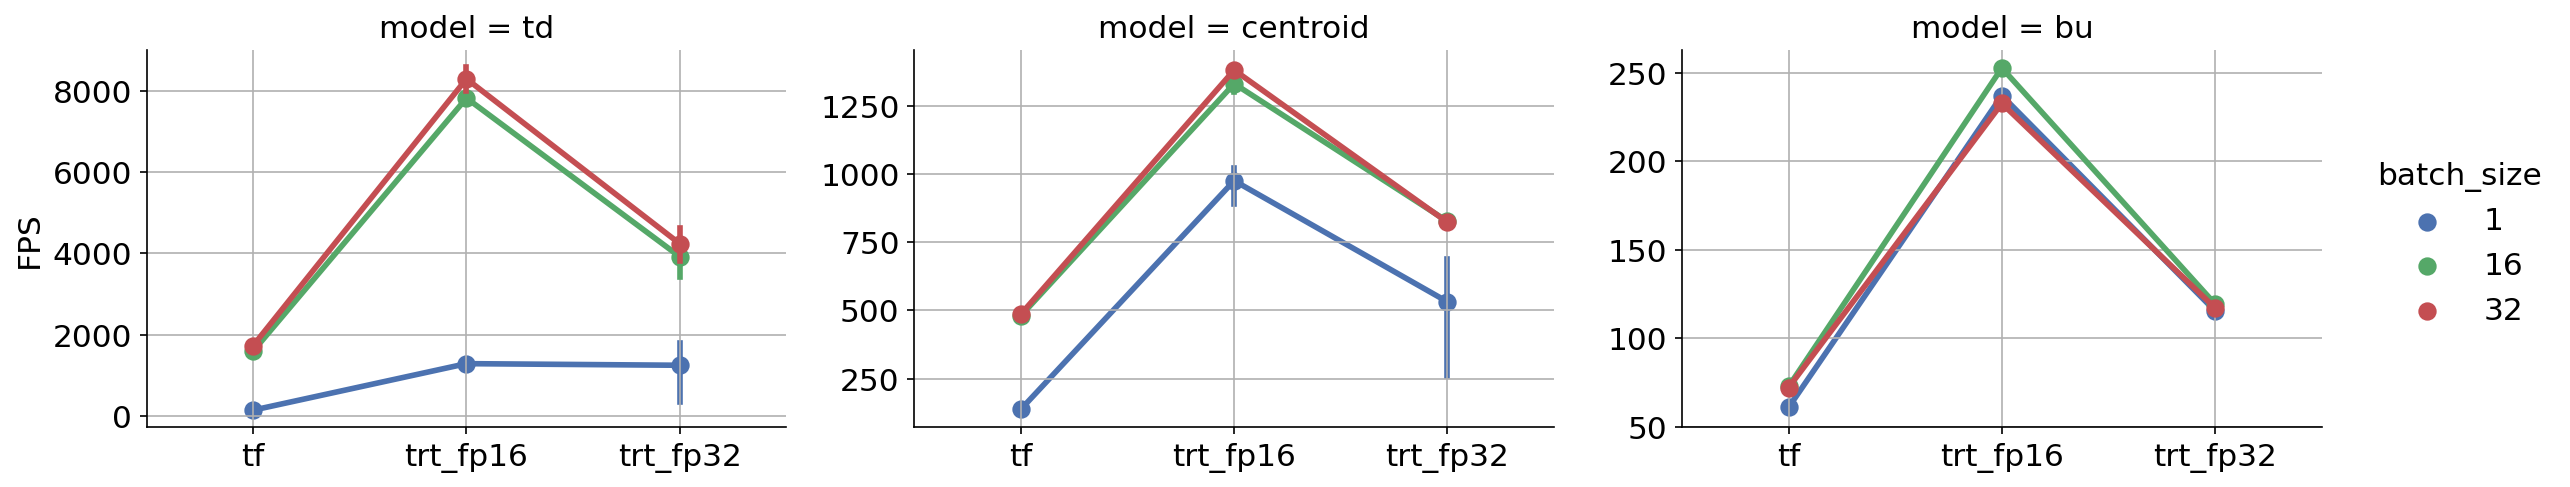

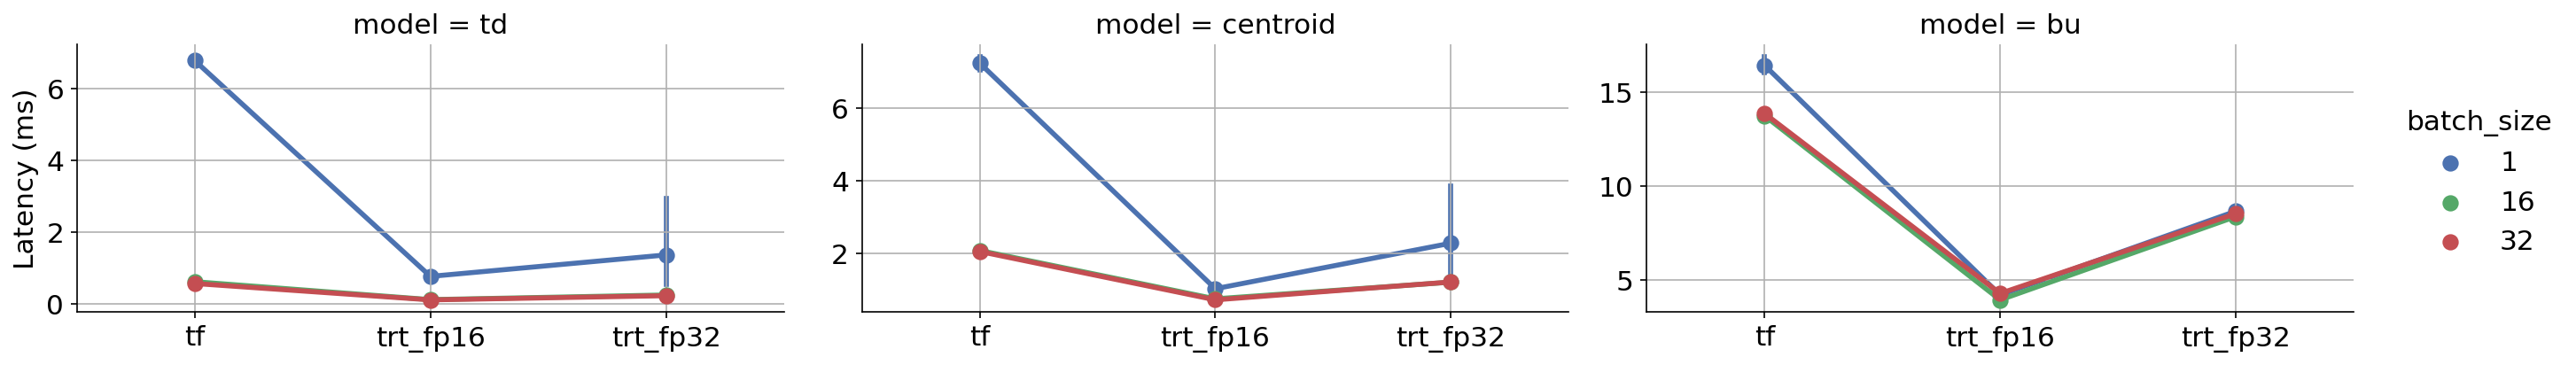

In [10]:
g = sns.catplot(
    data=res.query("model in ['centroid', 'td', 'bu']"),
    x="engine", y="fps", hue="batch_size", col="model", kind="point",
    order=["tf", "trt_fp16", "trt_fp32"],
    height=3.5, aspect=1.5, legend_out=True, sharey=False
)
g.map(lambda color: plt.grid(True))
g.set_ylabels("FPS")
plt.savefig("speed.png", facecolor="w")

g = sns.catplot(
    data=res.query("model != 'inference_td'"),
    x="engine", y="latency", hue="batch_size", col="model", kind="point",
    order=["tf", "trt_fp16", "trt_fp32"],
    height=3, aspect=2, legend_out=True, sharey=False
)
g.map(lambda color: plt.grid(True));
g.set_ylabels("Latency (ms)")
plt.savefig("latency.png", facecolor="w")

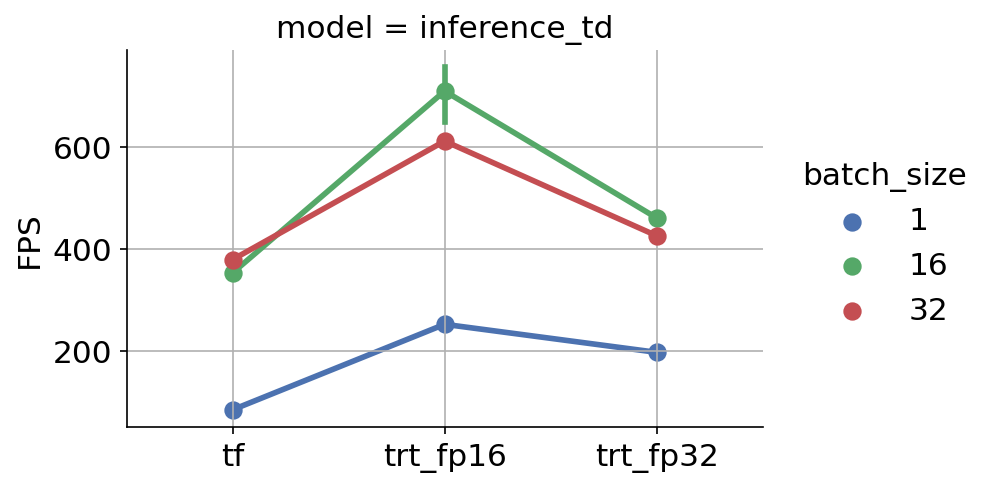

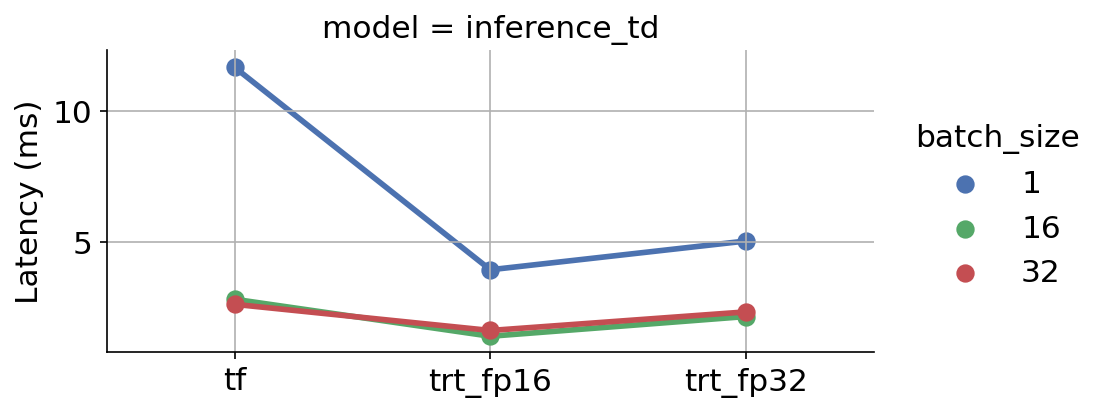

In [11]:
g = sns.catplot(
    data=res.query("model in ['inference_td']"),
    x="engine", y="fps", hue="batch_size", col="model", kind="point",
    order=["tf", "trt_fp16", "trt_fp32"],
    height=3.5, aspect=1.5, legend_out=True, sharey=False
)
g.map(lambda color: plt.grid(True))
g.set_ylabels("FPS")
plt.savefig("speed.inference_model.png", facecolor="w")

g = sns.catplot(
    data=res.query("model in ['inference_td']"),
    x="engine", y="latency", hue="batch_size", col="model", kind="point",
    order=["tf", "trt_fp16", "trt_fp32"],
    height=3, aspect=2, legend_out=True, sharey=False
)
g.map(lambda color: plt.grid(True));
g.set_ylabels("Latency (ms)")
plt.savefig("latency.inference_model.png", facecolor="w")